<a href="https://colab.research.google.com/github/NavinMundhra/06_employee_attrition_rate/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hello everyone, this notebook is for a [competition for beginners at Hackerearth](https://www.hackerearth.com/challenges/competitive/hackerearth-machine-learning-challenge-predict-employee-attrition-rate/machine-learning/predict-the-employee-attrition-rate-in-organizations-1d700a97/) which I am competing in. This is to give a brief overview to beginners on what to do and what not to do in a competition. Starting from today, I am going to update this everyday to improve my score. You can find the problem statement below. 

Comment your suggestions and take part in the competition. The last date for submission is June 30th, 2020.

Upvote if you like the notebook. Cheers! :)

# Predict the employee attrition rate in organizations

### Problem statement
Employees are the most important part of an organization. Successful employees meet deadlines, make sales, and build the brand through positive customer interactions.

Employee attrition is a major cost to an organization and predicting such attritions is the most important requirement of the Human Resources department in many organizations. In this problem, your task is to predict the attrition rate of employees of an organization.

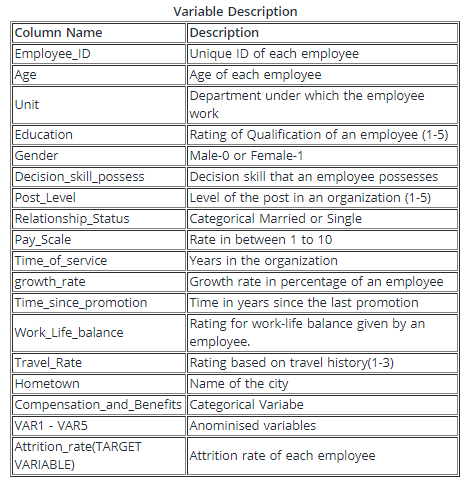
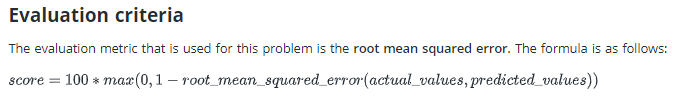

# IMPORTS & DATA EXPLORATION

In [ ]:
PATH = 'drive/My Drive/Colab Notebooks/proj_6 - employee_attrition_rate/Dataset'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8,6)
import seaborn as sns
sns.set(style='darkgrid')
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing as prep

In [ ]:
test = pd.read_csv(PATH+'/Test.csv')
train = pd.read_csv(PATH+'/Train.csv')
sample = pd.read_csv(PATH+'/sample_submission.csv')

train.shape, test.shape

((7000, 24), (3000, 23))

### Lets see how the data looks like

In [ ]:
target = 'Attrition_rate'
catfeat, numfeat = list(train.select_dtypes(exclude=np.number)), list(train.select_dtypes(include=np.number))
numfeat.remove(target)

df = pd.concat([train,test], keys=['train', 'test'])
df

Employee_ID Gender   Age  ...  VAR6 VAR7 Attrition_rate
train 0      EID_23371      F  42.0  ...     5    3         0.1841
      1      EID_18000      M  24.0  ...     5    3         0.0670
      2       EID_3891      F  58.0  ...     8    3         0.0851
      3      EID_17492      F  26.0  ...     7    3         0.0668
      4      EID_22534      F  31.0  ...     8    2         0.1827
...                ...    ...   ...  ...   ...  ...            ...
test  2995   EID_22547      F  32.0  ...     7    4            NaN
      2996   EID_10066      F   NaN  ...     8    3            NaN
      2997    EID_7126      F  60.0  ...     8    4            NaN
      2998    EID_4929      F  51.0  ...     9    2            NaN
      2999   EID_24750      F  45.0  ...     8    5            NaN

[10000 rows x 24 columns]

### A brief intro to the data


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10000 entries, ('train', 0) to ('test', 2999)
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Employee_ID                10000 non-null  object 
 1   Gender                     10000 non-null  object 
 2   Age                        9427 non-null   float64
 3   Education_Level            10000 non-null  int64  
 4   Relationship_Status        10000 non-null  object 
 5   Hometown                   10000 non-null  object 
 6   Unit                       10000 non-null  object 
 7   Decision_skill_possess     10000 non-null  object 
 8   Time_of_service            9804 non-null   float64
 9   Time_since_promotion       10000 non-null  int64  
 10  growth_rate                10000 non-null  int64  
 11  Travel_Rate                10000 non-null  int64  
 12  Post_Level                 10000 non-null  int64  
 13  Pay_Scale                 

In [ ]:
# from scipy import special
# df.xs('train')[target] = special.boxcox1p(df.xs('train')[target], stats.boxcox_normmax(1+df.xs('train')[target]))
# sns.distplot(df.xs('train')[target], label='Skew: {:.4f}'.format(df.xs('train')[target].skew())); plt.legend(); 

# DATA PREPROCESSING

### Data Cleaning

##### Dealing with missing data

In [ ]:
## CREATING A TEMPORARY DATAFRAME TO HANDLE MISSING VALUES
temp = pd.concat([df['Age'], df['Time_of_service'], df['Pay_Scale'], df['Work_Life_balance'], df['VAR2'], df['VAR4']], axis=1)

Since the data is about employees, we expect age and time of service to be highly correlated (given the assumption that your employee is loyal to you).

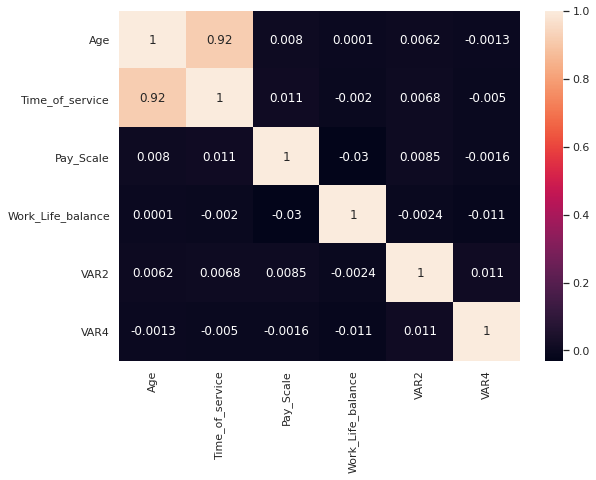

In [ ]:
sns.heatmap(temp.corr(), annot = True); plt.show()

Indeed, the employees are definitely loyal. 

In [ ]:
## PERCENT OF MISSING VALUES
temp.isnull().sum()/len(temp)*100

Age                  5.73
Time_of_service      1.96
Pay_Scale            0.12
Work_Life_balance    0.16
VAR2                 7.94
VAR4                 9.54
dtype: float64

Not much values are missing. We wanna see how we will handle them now based on their datatype.

In [ ]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10000 entries, ('train', 0) to ('test', 2999)
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                9427 non-null   float64
 1   Time_of_service    9804 non-null   float64
 2   Pay_Scale          9988 non-null   float64
 3   Work_Life_balance  9984 non-null   float64
 4   VAR2               9206 non-null   float64
 5   VAR4               9046 non-null   float64
dtypes: float64(6)
memory usage: 552.8+ KB


All are numerical values! 

If you think about filling with mean or median, you gotta check the skewness of data. Skewness gives you a quick overview of Normal Distribution of the data.

In [ ]:
temp.nunique()

Age                  47
Time_of_service      44
Pay_Scale            10
Work_Life_balance     5
VAR2                  5
VAR4                  3
dtype: int64

In [ ]:
print('Skewness: '); print(temp.skew())

Skewness: 
Age                  0.228507
Time_of_service      0.785758
Pay_Scale           -0.259408
Work_Life_balance    0.203832
VAR2                -0.445757
VAR4                -0.091472
dtype: float64


The data does not have much skewness. We can safely fill with either mean or median (I would prefer and suggest median over mean anyday)

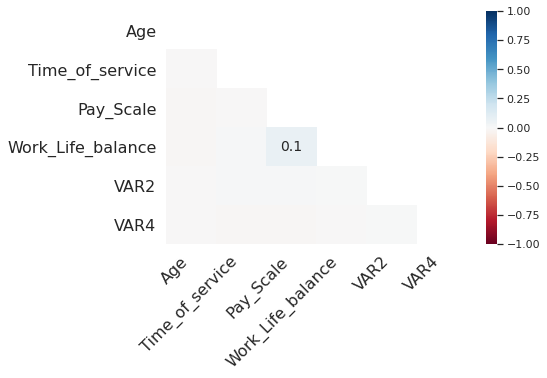

In [ ]:
import missingno as mnso; mnso.heatmap(temp, figsize=(6,4)); plt.show()

The above heatmap shows the correlation of missingness between every 2 column.

A value near -1 means if one variable appears then the other variable is very likely to be missing. A value near 0 means there is no dependence between the occurrence of missing values of two variables. A value near 1 means if one variable appears then the other variable is very likely to be present. 

This property is not shown by out missing values so we can fill them independently.

In [ ]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Time_of_service'] = df.groupby('Age')['Time_of_service'].transform(lambda x: x.fillna(x.median()))
df['Pay_Scale'].fillna(df['Pay_Scale'].median(), inplace=True)
df['Work_Life_balance'].fillna(df['Work_Life_balance'].median(), inplace=True)
# df['VAR2'] = df['VAR2'].astype('str')
# df['VAR2'].fillna(df['VAR2'].mode()[0], inplace=True)
df['VAR2'].fillna(df['VAR2'].median(), inplace=True)
df['VAR4'] = df['VAR4'].astype('str')
df['VAR4'].fillna(df['VAR4'].mode()[0], inplace=True)
# df['VAR6'] = df['VAR6'].astype('str')
# df['VAR1'] = df['VAR1'].astype('str')

catfeat, numfeat = list(df.select_dtypes(exclude=np.number)), list(df.select_dtypes(include=np.number))
numfeat.remove(target)

In [ ]:
df.isnull().sum()

Employee_ID                     0
Gender                          0
Age                             0
Education_Level                 0
Relationship_Status             0
Hometown                        0
Unit                            0
Decision_skill_possess          0
Time_of_service                 0
Time_since_promotion            0
growth_rate                     0
Travel_Rate                     0
Post_Level                      0
Pay_Scale                       0
Compensation_and_Benefits       0
Work_Life_balance               0
VAR1                            0
VAR2                            0
VAR3                            0
VAR4                            0
VAR5                            0
VAR6                            0
VAR7                            0
Attrition_rate               3000
dtype: int64

In [ ]:
df

Employee_ID Gender   Age  ...  VAR6 VAR7 Attrition_rate
train 0      EID_23371      F  42.0  ...     5    3         0.1841
      1      EID_18000      M  24.0  ...     5    3         0.0670
      2       EID_3891      F  58.0  ...     8    3         0.0851
      3      EID_17492      F  26.0  ...     7    3         0.0668
      4      EID_22534      F  31.0  ...     8    2         0.1827
...                ...    ...   ...  ...   ...  ...            ...
test  2995   EID_22547      F  32.0  ...     7    4            NaN
      2996   EID_10066      F  38.0  ...     8    3            NaN
      2997    EID_7126      F  60.0  ...     8    4            NaN
      2998    EID_4929      F  51.0  ...     9    2            NaN
      2999   EID_24750      F  45.0  ...     8    5            NaN

[10000 rows x 24 columns]

##### Dealing with outliers

##### Transforming features

In [ ]:
df[numfeat].describe()

,Age,Education_Level,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,VAR1,VAR2,VAR3,VAR5,VAR6,VAR7
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,39.579500,3.199400,13.411000,2.37860,47.008400,0.820700,2.797000,6.022600,2.385200,3.089100,-0.005879,-0.005826,2.834800,7.110000,3.249600
std,13.185912,1.065436,10.297518,1.14978,15.848553,0.646524,1.171037,2.068844,1.127984,0.831884,0.953152,0.990812,0.939466,1.160877,0.918795
min,19.000000,1.000000,0.000000,0.00000,20.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-1.817600,-2.776200,1.000000,5.000000,1.000000
25%,28.000000,3.000000,5.000000,1.00000,33.000000,0.000000,2.000000,5.000000,1.000000,3.000000,-0.961200,-0.453700,2.000000,6.000000,3.000000
50%,38.000000,3.000000,10.000000,2.00000,47.000000,1.000000,3.000000,6.000000,2.000000,3.000000,-0.104800,-0.453700,3.000000,7.000000,3.000000
75%,51.000000,4.000000,21.000000,3.00000,61.000000,1.000000,4.000000,8.000000,3.000000,3.000000,0.751600,0.707500,3.000000,8.000000,4.000000
max,65.000000,5.000000,43.000000,4.00000,74.000000,2.000000,5.000000,10.000000,5.000000,5.000000,1.608100,1.868800,5.000000,9.000000,5.000000


In [ ]:
for col in numfeat:
    df[col] = stats.boxcox(3+df[col], stats.boxcox_normmax(3+df[col]))

### Feature Engineering

In [ ]:
df

Employee_ID Gender       Age  ...        VAR6      VAR7 Attrition_rate
train 0      EID_23371      F  6.511767  ...  160.587266  4.746429         0.1841
      1      EID_18000      M  5.221626  ...  160.587266  4.746429         0.0670
      2       EID_3891      F  7.365788  ...  413.538034  4.746429         0.0851
      3      EID_17492      F  5.391934  ...  311.613729  4.746429         0.0668
      4      EID_22534      F  5.782619  ...  413.538034  3.820939         0.1827
...                ...    ...       ...  ...         ...       ...            ...
test  2995   EID_22547      F  5.855578  ...  311.613729  5.664901            NaN
      2996   EID_10066      F  6.263679  ...  413.538034  4.746429            NaN
      2997    EID_7126      F  7.460391  ...  413.538034  5.664901            NaN
      2998    EID_4929      F  7.015452  ...  535.412187  3.820939            NaN
      2999   EID_24750      F  6.687331  ...  413.538034  6.577406            NaN

[10000 rows x 24 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10000 entries, ('train', 0) to ('test', 2999)
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Employee_ID                10000 non-null  object 
 1   Gender                     10000 non-null  object 
 2   Age                        10000 non-null  float64
 3   Education_Level            10000 non-null  float64
 4   Relationship_Status        10000 non-null  object 
 5   Hometown                   10000 non-null  object 
 6   Unit                       10000 non-null  object 
 7   Decision_skill_possess     10000 non-null  object 
 8   Time_of_service            10000 non-null  float64
 9   Time_since_promotion       10000 non-null  float64
 10  growth_rate                10000 non-null  float64
 11  Travel_Rate                10000 non-null  float64
 12  Post_Level                 10000 non-null  float64
 13  Pay_Scale                 

In [ ]:
df['Age_Group'] = pd.cut(df['Age'], [18,35,50,70], labels = ['Young', 'Middle_Aged', 'Old'])
df['Pay_Scale'] = df['Pay_Scale'].max() - df['Pay_Scale']
df['growth_rate'] = df['growth_rate'].max() - df['growth_rate']
df['tos_timesincepromo'] = abs(df['Time_of_service']-df['Time_since_promotion'])
df['level'] = abs(df['Post_Level']- df['Education_Level'])
df['tr_wlb'] = df['Work_Life_balance']/df['Travel_Rate']
df['tos_whole'] = np.fix(df['Time_of_service'])
df['tos_frac'] = df['Time_of_service'] - np.fix(df['Time_of_service'])
df['VAR'] = (df['VAR1']+df['VAR2']+df['VAR3']+df['VAR5']+df['VAR7'])/5
df['VAR_sqrt'] = np.sqrt(df['VAR1']**2+df['VAR2']**2+df['VAR3']**2+df['VAR5']**2+df['VAR7']**2)

### Transforming data for model fitting

In [ ]:
minmax = prep.MinMaxScaler()
df[numfeat] = minmax.fit_transform(df[numfeat])

In [ ]:
df.drop('Employee_ID', axis=1, inplace=True)

df1= pd.get_dummies(df)

x, y, X_test = df1.xs('train').drop(target, axis=1), df1.xs('train')[target], df1.xs('test').drop(target,axis=1)
x.shape, y.shape, X_test.shape

((7000, 59), (7000,), (3000, 59))

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=3)

# x = pca.fit_transform(x)
# X_test = pca.fit_transform(X_test)
# x, X_test= pd.DataFrame(x),pd.DataFrame(X_test) 
# x.shape, X_test.shape

# MODEL FITTING

### LGBoost

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold


lgbmodel, scores, scoresd = lgb.LGBMRegressor(silent=True), list(), dict()


kf = KFold(n_splits=15,shuffle = True, random_state=100)

for train, test in kf.split(x,y):
    x_train, y_train = x.loc[train], y.loc[train]
    x_test, y_test = x.loc[test], y.loc[test]

    lgbmodel.fit(x_train,y_train, early_stopping_rounds=100, verbose=False, eval_metric='mean_squared_error', eval_set=(x_test,y_test))
    y_pred = lgbmodel.predict(x_test)
    
    temp = mean_squared_error(y_pred,y_test)
    scores.append(100*max(0,1-(np.sqrt(temp))))

scoresd['baseline_lgb'] = sum(scores)/len(scores)
print('CV(', kf.get_n_splits(), ') score: ', scoresd['baseline_lgb'])

CV( 15 ) score:  81.49504397735751


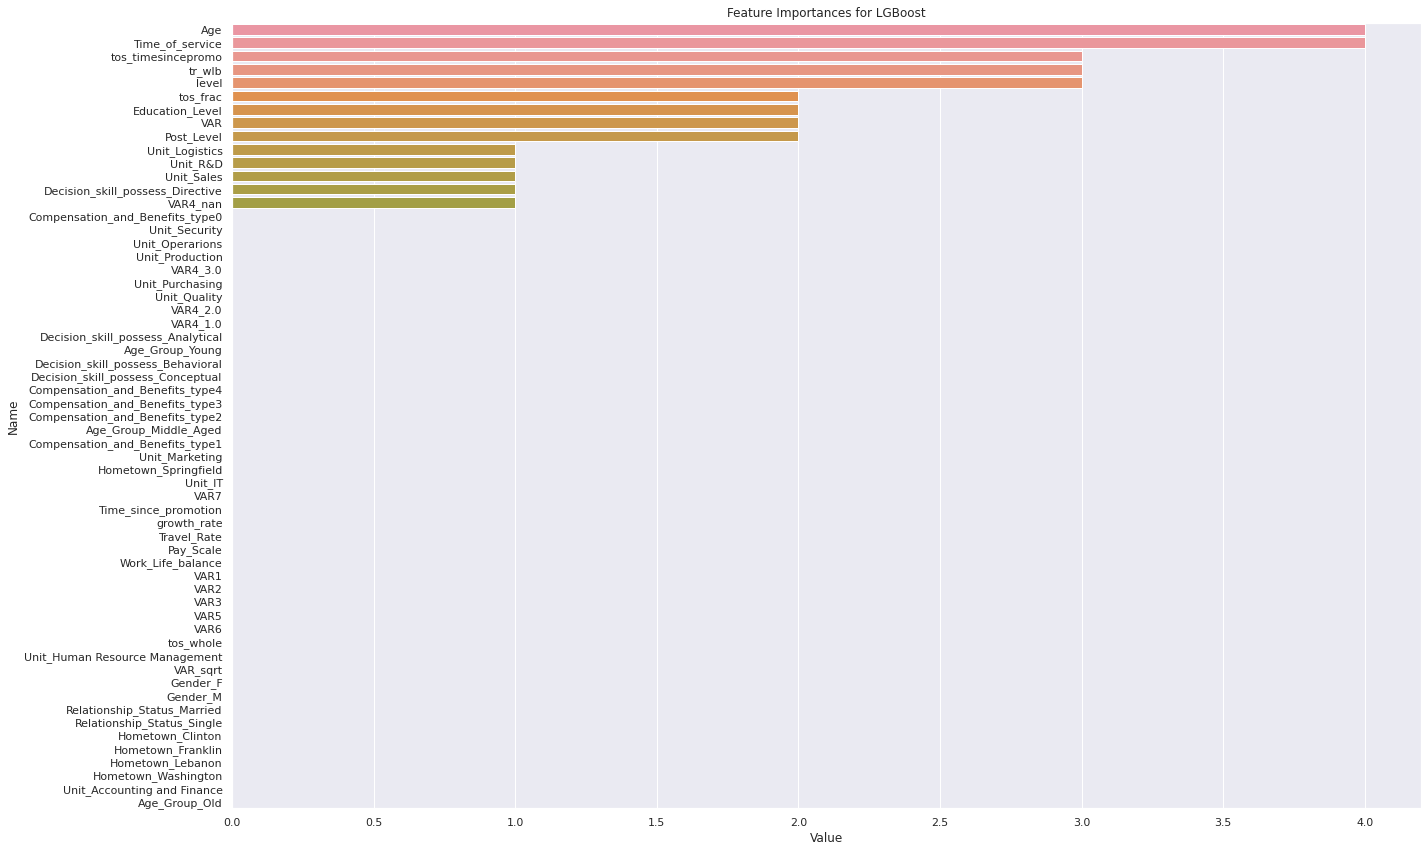

In [ ]:
imp = pd.concat([pd.Series(lgbmodel.feature_importances_), pd.Series(list(x.columns))], keys = ['Value', 'Name'], axis=1)

plt.figure(figsize=(20,12))
sns.barplot(x='Value', y='Name', data= imp.sort_values(by='Value', ascending=False))
plt.title('Feature Importances for LGBoost')
plt.tight_layout()

I am going to use these feature importances to create new features in the feature engineering section which was left empty.

In [ ]:
# PARAMETER TUNING TO BE DONE
from sklearn.model_selection import RandomizedSearchCV

max_depth = [int(x) for x in np.linspace(20,100,10)]


lgbparams = {'max_depth':max_depth, 
             
             }

### CatBoost

In [ ]:
# ! pip install catboost
from catboost import CatBoostRegressor

cbr, scores = CatBoostRegressor(learning_rate=0.01), list()

for train, test in kf.split(x,y):
    x_train, y_train = x.loc[train], y.loc[train]
    x_test, y_test = x.loc[test], y.loc[test]

    cbr.fit(x_train,y_train, early_stopping_rounds=100, verbose=False)
    y_pred = cbr.predict(x_test)
    
    temp = mean_squared_error(y_pred,y_test)
    scores.append(100*max(0,1-(np.sqrt(temp))))

scoresd['catboost'] = sum(scores)/len(scores)
print('CV(', kf.get_n_splits(), ') score: ', scoresd['catboost'])

In [ ]:
cbr.get_params()

### XGBoost

In [ ]:
import xgboost as xgb

xgbmodel, scores = xgb.XGBRegressor(), list()

for train, test in kf.split(x,y):
    x_train, y_train = x.loc[train], y.loc[train]
    x_test, y_test = x.loc[test], y.loc[test]

    xgbmodel.fit(x_train,y_train, verbose=False)
    y_pred = xgbmodel.predict(x_test)

    temp = mean_squared_error(y_pred,y_test)
    scores.append(100*max(0,1-np.sqrt(temp)))
    
scoresd['baseline_XGB'] = sum(scores)/len(scores)
print('CV(', kf.get_n_splits(), ') score: ', scoresd['baseline_XGB'])

In [ ]:
imp = pd.concat([pd.Series(xgbmodel.feature_importances_), pd.Series(list(x.columns))], keys = ['Value', 'Name'], axis=1)

plt.figure(figsize=(20,12))
sns.barplot(x='Value', y='Name', data= imp.sort_values(by='Value', ascending=False))
plt.title('Feature Importances for XGBoost')
plt.tight_layout()

### Lasso

In [ ]:
from sklearn.linear_model import Lasso 
from sklearn import model_selection as ms
parameters= {'alpha':[0.0001,0.0009,0.001,0.01,0.1,1,10],
            'max_iter':[100,500,1000, 50, 20]
             }


lasso = Lasso()
lasso_model = ms.GridSearchCV(lasso, param_grid=parameters, cv=10)
lasso_model.fit(x,y)

print('The best value of Alpha is: ',lasso_model.best_params_)

The best value of Alpha is:  {'alpha': 0.001, 'max_iter': 20}


In [ ]:
lss, scores = Lasso(alpha=0.001, max_iter=20), list()

for train, test in kf.split(x,y):
    x_train, y_train = x.loc[train], y.loc[train]
    x_test, y_test = x.loc[test], y.loc[test]

    lss.fit(x_train,y_train)
    y_pred = lss.predict(x_test)

    temp = mean_squared_error(y_pred,y_test)
    scores.append(100*max(0,1-np.sqrt(temp)))
    
scoresd['lasso'] = sum(scores)/len(scores)
print('CV(', kf.get_n_splits(), ') score: ', scoresd['lasso'])

CV( 15 ) score:  81.45531079926403


### ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet 

enet, scores = ElasticNet(random_state=100), list()

for train, test in kf.split(x,y):
    x_train, y_train = x.loc[train], y.loc[train]
    x_test, y_test = x.loc[test], y.loc[test]

    enet.fit(x_train,y_train)
    y_pred = enet.predict(x_test)

    temp = mean_squared_error(y_pred,y_test)
    scores.append(100*max(0,1-np.sqrt(temp)))
    
scoresd['enet'] = sum(scores)/len(scores)
print('CV(', kf.get_n_splits(), ') score: ', scoresd['enet'])

# BLENDING & SUBMISSION

In [ ]:
scoresd

Baseline lgb seems to be doing better (for now). So, blending will be biased towards it.

In [ ]:
lgbmodel.fit(x,y)
# xgbmodel.fit(x,y)
# cbr.fit(x,y, verbose=False)
lss.fit(x,y)

lgb_Y_pred = lgbmodel.predict(X_test)
# xgb_Y_pred = xgbmodel.predict(X_test)
# cbr_Y_pred = cbr.predict(X_test)
lasso_Y_pred = lss.predict(X_test)


Y_pred = lgb_Y_pred

Y_pred.shape

(3000,)

In [ ]:
# Y_pred = special.inv_boxcox1p(Y_pred, stats.boxcox_normmax(1+df.xs('train')[target]))
Y_pred

array([0.22716407, 0.18495916, 0.17080267, ..., 0.16910403, 0.25887898,
       0.22512221])

In [ ]:
test = pd.read_csv(PATH+'/Test.csv')
sample = pd.concat([test['Employee_ID'], pd.Series(Y_pred*0.99)], keys = ('Employee_ID', target), axis=1)
sample.to_csv(PATH+'/blend08.csv', index=False)

### Now work is to:-
* Apply more models
* Feature engineering
* Parameter tuning for models


### References:-
* [lightGBM documentation](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)
* [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/)
* [Pandas documentation](https://pandas.pydata.org/docs/)
* [Amazing notebook](https://www.kaggle.com/twinkle0705/a-comprehensive-guide-to-handle-missing-values#2.Checking-for-Missing-values-visually) on missing value handling
* [My Notebook](https://www.kaggle.com/navinmundhra/data-pre-processing-advanced-outlier-handling) on outlier handling
* [Notebook](https://www.kaggle.com/risabbiswas19/ensembling-for-regression-top-6-on-lb/notebook) on Ensembling methods for regression